# XGBoost
This Notebook presents tests to tune hyperparameters for a Gradient Tree Boosting with XGBoost model and present results obtained during training. The general description of such model can be found in the report.

In [3]:
import sys
sys.path.append('../src')
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from movies_preprocessing import full_processing
from dataset_split import train_test_split_perso
from evaluation import get_n_accuracies_test, get_n_accuracies_train

In [4]:
df = pd.read_csv('../data/training.csv')
features = ["year_film", "genres", "averageRating", "dir_won_before", "budget", "nb_actor_won_before","won_bafta","won_gg_drama","won_gg_comedy", "runtimeMinutes"]
X = df[features]
X_processed = full_processing(X, "median")
y = df['winner']
X_train, X_test, y_train, y_test = train_test_split_perso(df, X_processed, y, 0.2)

/Users/emile/Desktop/MLProject/Notebooks/../src/movies_preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def genre_encoding(df):


## Baseline Model
As for other models we start with a baseline model with default parameters.

In [5]:
model = XGBClassifier(scale_pos_weight = 0.1)
model.fit(X_train, y_train)
top1, top3 =  get_n_accuracies_test(model, df, X_processed, y, 100)
print(np.mean(top1), np.mean(top3))

0.49705882352941183 0.8388235294117646


## Hyper parameters tuning 
The **XGBoost classifier** offers a lot of hyperparameters we can tune to mitigate overfitting and improve results. Among them, some are similar to those used in Random Forest, such as:

- The **maximum depth** of the trees.
- The **number of estimators** (trees in the ensemble).

In addition to those, XGBoost also supports:

- **L2 (ridge) and L1 (lasso) regularization**.
- The **learning rate**, which controls how quickly the model adapts to the data.

By performing a grid search over these parameters, we observe that:

- The best-performing models tend to have around **200 estimators**. Using more does not provide better results and only increases training time.
- The most effective **learning rates** are around **0.01**.

By fixing these parameters, we can then explore more precise values for **maximum depth** and **regularization strength**.


In [6]:
#This part takes a while to run results are avaible below or directly in the report
# Define hyperparameter values
depths = [3, 5, 10]
n_trees = [100, 200, 1000]
learning_rates = [0.01, 0.1]
scale_pos_weights = [1, 5]
reg_lambdas = [0, 1, 10]  # L2 regularization

results_training = []
results_validation = []

for d in depths:
    for n in n_trees:
        for lr in learning_rates:
            for spw in scale_pos_weights:
                for reg in reg_lambdas:
                    model = XGBClassifier(
                        n_estimators=n,
                        max_depth=d,
                        learning_rate=lr,
                        scale_pos_weight=spw,
                        reg_lambda=reg,
                        use_label_encoder=False,
                        eval_metric='logloss',
                        verbosity=0,
                    )
                    
                    # Compute top1 accuracy on training
                    top1_train = get_n_accuracies_train(model, df, X_processed, y, 100)[0]
                    results_training.append({
                        'max_depth': d,
                        'n_estimators': n,
                        'learning_rate': lr,
                        'scale_pos_weight': spw,
                        'reg_lambda': reg,
                        'top1_accuracy': np.mean(top1_train)
                    })

                    # Compute top1 accuracy on validation
                    top1_val = get_n_accuracies_test(model, df, X_processed, y, 100)[0]
                    results_validation.append({
                        'max_depth': d,
                        'n_estimators': n,
                        'learning_rate': lr,
                        'scale_pos_weight': spw,
                        'reg_lambda': reg,
                        'top1_accuracy': np.mean(top1_val)
                    })

# Convert results to DataFrames
df_train_results = pd.DataFrame(results_training)
df_val_results = pd.DataFrame(results_validation)

# Display nicely sorted validation results
print("Validation Top-1 Accuracy (sorted):")
print(df_val_results.sort_values(by="top1_accuracy", ascending=False).head(10).to_string(index=False))


Validation Top-1 Accuracy (sorted):
 max_depth  n_estimators  learning_rate  scale_pos_weight  reg_lambda  top1_accuracy
         5           200           0.01                 1           0       0.535882
        10           100           0.01                 1           0       0.535294
        10           100           0.01                 1          10       0.531765
         3           100           0.01                 1           0       0.529412
         5          1000           0.01                 1           0       0.528824
         3           200           0.01                 1           0       0.528824
         3           200           0.01                 5          10       0.527059
         3           100           0.01                 5          10       0.525294
         3           100           0.01                 5           1       0.524118
         3           200           0.01                 5           1       0.524118


In [7]:
results_training = []
results_validation = []
depths = [1, 2, 3, 4, 5,6]
lambdas = [0, 1, 5, 10]
for d in depths:
    for l2 in lambdas:
        model = XGBClassifier(
                        n_estimators=200,
                        max_depth=d,
                        learning_rate=0.01,
                        reg_lambda=l2,
                        use_label_encoder=False,
                        eval_metric='logloss',
                        verbosity=0,
                    )
        # Compute training accuracy
        top1_train = get_n_accuracies_train(model, df, X_processed, y, 100)[0]
        results_training.append({
            'max_depth': d,
            'lambda': l2,
            'top1_accuracy': np.mean(top1_train)
        })
        
        # Compute validation accuracy
        top1_val = get_n_accuracies_test(model, df, X_processed, y, 100)[0]
        results_validation.append({
            'max_depth': d,
            'lambda': l2,
            'top1_accuracy': np.mean(top1_val)
        })

In [ ]:
results_training = []
results_validation = []
depths = [1, 2, 3, 4, 5,6]
lambdas = [0, 1, 5, 10]
for d in depths:
    for l2 in lambdas:
        model = XGBClassifier(
                        n_estimators=200,
                        max_depth=d,
                        learning_rate=0.01,
                        reg_lambda=l2,
                        use_label_encoder=False,
                        eval_metric='logloss',
                        verbosity=0,
                    )
        # Compute training accuracy
        top1_train = get_n_accuracies_train(model, df, X_processed, y, 100)[0]
        results_training.append({
            'max_depth': d,
            'lambda': l2,
            'top1_accuracy': np.mean(top1_train)
        })
        
        # Compute validation accuracy
        top1_val = get_n_accuracies_test(model, df, X_processed, y, 100)[0]
        results_validation.append({
            'max_depth': d,
            'lambda': l2,
            'top1_accuracy': np.mean(top1_val)
        })


We have the following results, as expected with deeper trees and no regularization the model is almost perfect when computing the accuracy on the training set. On the validation set the results are a bit unexpected, the model with the best score is the one with the highest tree depth and no regularization. However, we also have competitive results with a depth of 3 and a regularization strength of 5. This model will probably adapt to the new data and choosing this one may be safer.

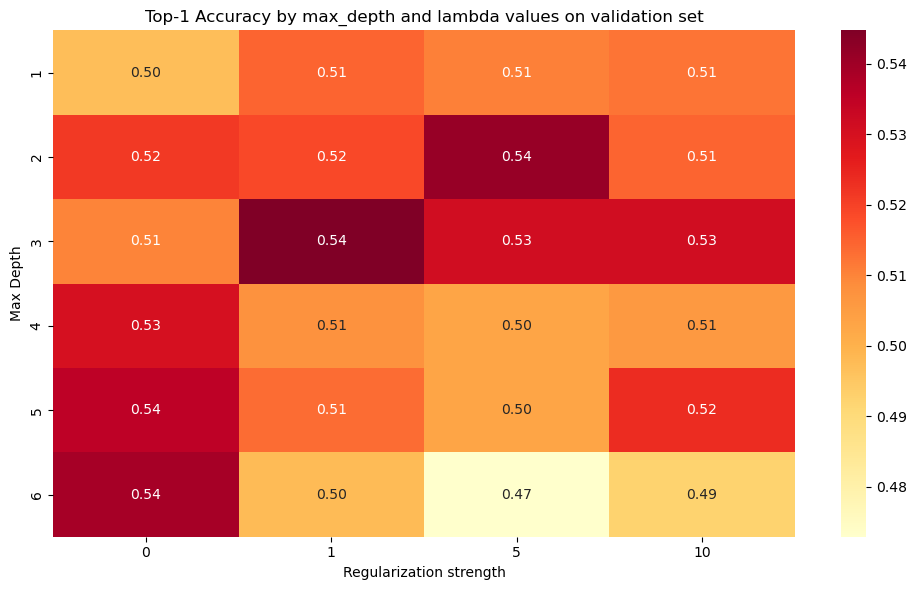

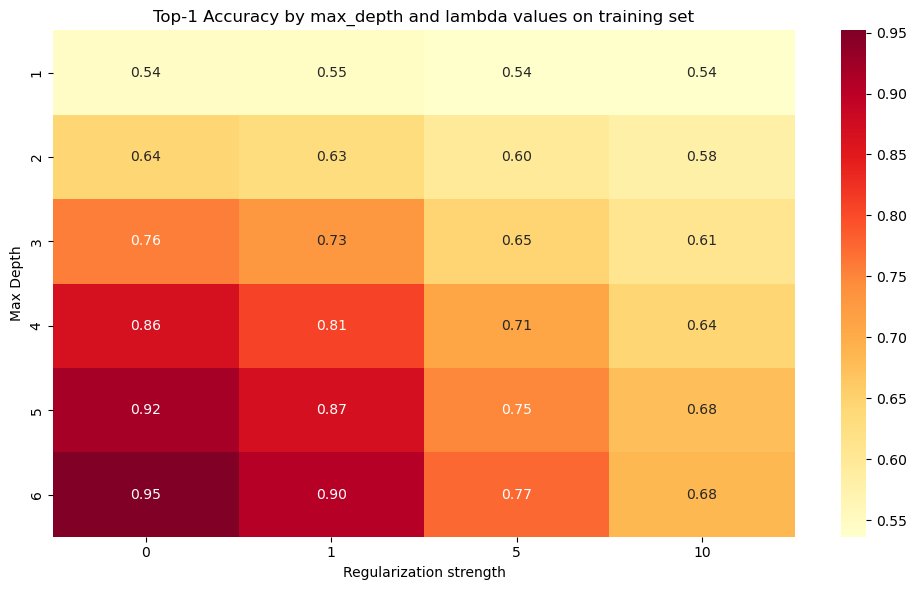

In [9]:
df_train = pd.DataFrame(results_training)
df_val = pd.DataFrame(results_validation)

train_pivot = df_train.pivot(index='max_depth', columns='lambda', values='top1_accuracy')
val_pivot = df_val.pivot(index='max_depth', columns='lambda', values='top1_accuracy')

#Plot for validation 
plt.figure(figsize=(10, 6))
sns.heatmap(val_pivot, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Top-1 Accuracy by max_depth and lambda values on validation set")
plt.xlabel("Regularization strength")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()
plt.close()

#Plot for training 
plt.figure(figsize=(10, 6))
sns.heatmap(train_pivot, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Top-1 Accuracy by max_depth and lambda values on training set")
plt.xlabel("Regularization strength")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()
plt.close()